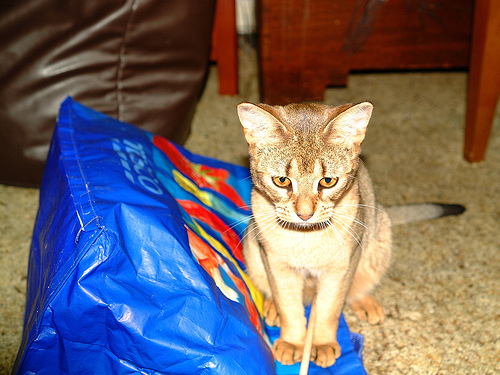

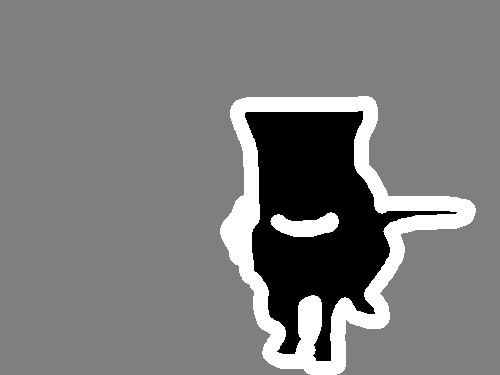

In [34]:
#pixel마다의 클래스 semantic image segmentation - 의미있는 것끼리 묶는다 dense prediction - 픽셀마다의 레이블이 들어가기 때문에 어려움

import os
input_dir = 'D:/OneDrive - 한국방송통신대학교/data/oxford pets/images/images'
target_dir = 'D:/OneDrive - 한국방송통신대학교/data/oxford pets/annotations/annotations/trimaps'
img_size = (160,160)
num_classes = 3
batch_size = 32
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('jpg')])
# print(input_img_paths)
# ['D:/OneDrive - 한국방송통신대학교/data/oxford pets/images/images\\Abyssinian_1.jpg', 'D:/OneDrive - 한국방송통신대학교/data/oxford pets/images/images\\Abyssinian_10.jpg', 'D:/OneDrive - 한국방송통신대학교
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png') and not fname.startswith('.')])
# print(target_img_paths)

from IPython.display import Image, display
from keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
display(Image(filename=input_img_paths[7]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)


In [35]:
#전처리
import numpy as np
import tensorflow as tf
import keras

class OxfordPets(keras.utils.all_utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths)// self.batch_size

    def __getitem__(self, idx):
        i = idx*self.batch_size #배치사이즈만큼 곱한 인덱스위치
        batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size+(3,), dtype = 'float32') #이미지 불러서 넣기 위한 빈자리
        
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8') #부호없는 정수 음수가 없는대신 양수를 두배저장 컬러모드 그레이스케일

        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(img, 2) #label이 123이지만 012로 만들기위함
            y[j] -= 1

        return x, y

In [36]:
import numpy as np
np.zeros(8 + 160 + 1, dtype='uint8')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [37]:
import random
val_samples = 1000
random.Random(1234).shuffle(input_img_paths)
random.Random(1234).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths) #나눴으므로
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [38]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(3,))
    
    x = layers.Conv2D(32,3,strides=2,padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for filters in [64,128,256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [256,128,64,32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x,residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size, num_classes)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 80, 80, 32)   896         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_33 (BatchN  (None, 80, 80, 32)  128         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks =[keras.callbacks.ModelCheckpoint('oxford_seg.h5', save_best_only=True)]

epoch =20
model.fit(train_gen, epochs=epoch, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
199/199 [==============================] - 242s 1s/step - loss: 0.9989 - val_loss: 1.4305
Epoch 2/20
199/199 [==============================] - 40s 200ms/step - loss: 0.5050 - val_loss: 2.0881
Epoch 3/20
199/199 [==============================] - 42s 208ms/step - loss: 0.4267 - val_loss: 0.4800
Epoch 4/20
199/199 [==============================] - 41s 205ms/step - loss: 0.3831 - val_loss: 0.4111
Epoch 5/20
199/199 [==============================] - 41s 208ms/step - loss: 0.3481 - val_loss: 0.4015
Epoch 6/20
199/199 [==============================] - 42s 212ms/step - loss: 0.3186 - val_loss: 0.3710
Epoch 7/20
199/199 [==============================] - 40s 200ms/step - loss: 0.2947 - val_loss: 0.3715
Epoch 8/20
199/199 [==============================] - 40s 199ms/step - loss: 0.2717 - val_loss: 0.3991
Epoch 9/20
199/199 [==============================] - 40s 202ms/step - loss: 0.2514 - val_loss: 0.4002
Epoch 10/20
199/199 [==============================] - 38s 191ms/step - los

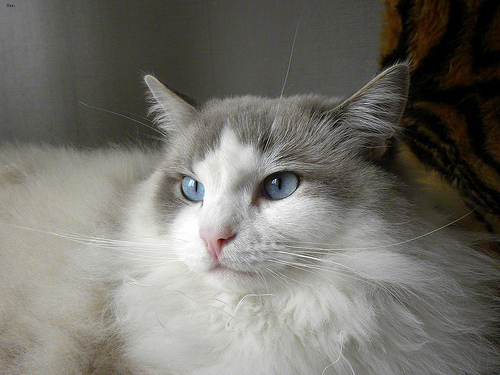

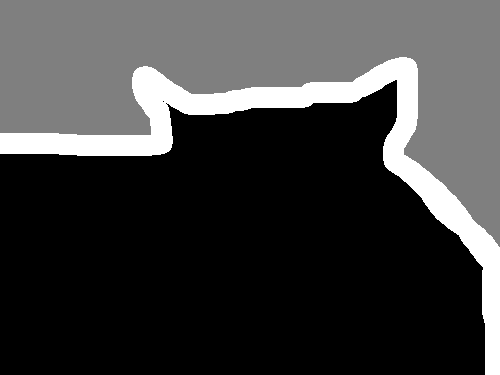

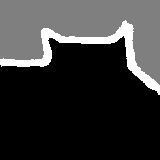

In [42]:
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

i = 20

display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)

In [43]:

img = load_img('D:/OneDrive - 한국방송통신대학교/data/custom_sample/1666765351202-4.jpg', target_size=(160,160))
img = x[1]
pred = model.predict(img)
mask = np.expand_dims(pred, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
display(img)

# i = 20

# display(Image(filename=val_input_img_paths[i]))
# # img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# # display(img)
# display_mask(i)

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>

In [45]:
x = np.zeros((32,) + (160,160)+(3,), dtype = 'float32') 
x.shape


(32, 160, 160, 3)

In [52]:

img = load_img('D:/OneDrive - 한국방송통신대학교/data/custom_sample/1666765351202-4.jpg', target_size=(160,160))
x[1] = img
pred = model.predict(x)
# mask = np.expand_dims(pred, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred))
display(img)

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (32, 160, 160, 3)

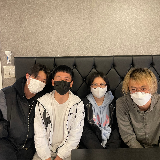

In [48]:

img = load_img('D:/OneDrive - 한국방송통신대학교/data/custom_sample/1666765351202-4.jpg', target_size=(160,160))
img